<a href="https://colab.research.google.com/github/LordRelentless/Innocentive-RUL-Nth-Mathematics-/blob/main/Innocentive_RUL_Nth_Mathematics_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

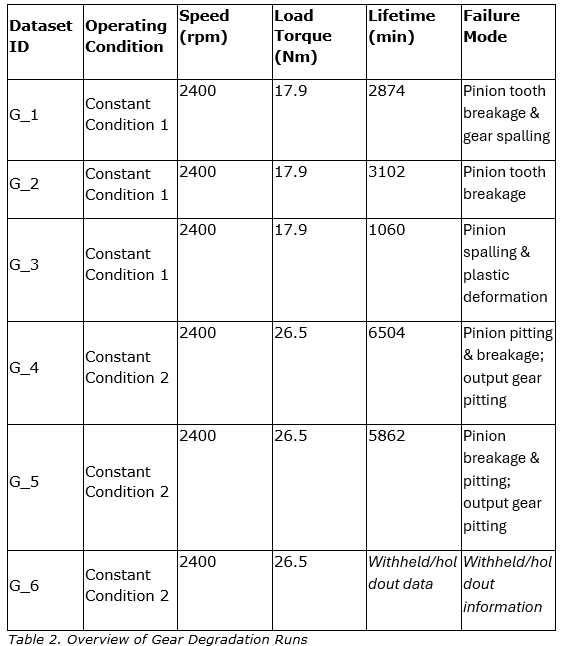
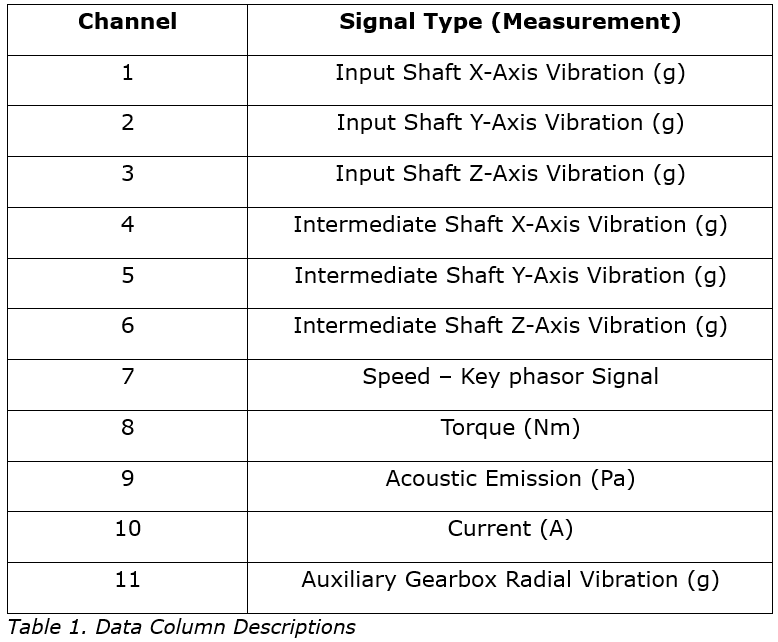

G1: Pinion Tooth Breakage and Gear Spawling; Speed RPM 2400, Torque: 17.9 Lifetime 2874 Minutes

G1 cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+5.120463e-07 per rev, R^2=0.459
Channel 2 (β): slope=+1.587085e-07 per rev, R^2=0.147
Channel 3 (γ): slope=+8.361115e-07 per rev, R^2=0.611
Channel 4 (δ): slope=+6.245101e-07 per rev, R^2=0.446
Channel 5 (ε): slope=+6.492190e-07 per rev, R^2=0.483
Channel 6 (ζ): slope=-1.286593e-07 per rev, R^2=0.063
Channel 7 (η): slope=+4.172171e-07 per rev, R^2=0.036
Channel 8 (θ): slope=+2.619207e-07 per rev, R^2=0.142
Channel 9 (ι): slope=+2.304449e-07 per rev, R^2=0.009
Channel 10 (κ): slope=-1.895115e-07 per rev, R^2=0.022
Channel 11 (λ): slope=+7.201089e-08 per rev, R^2=0.029


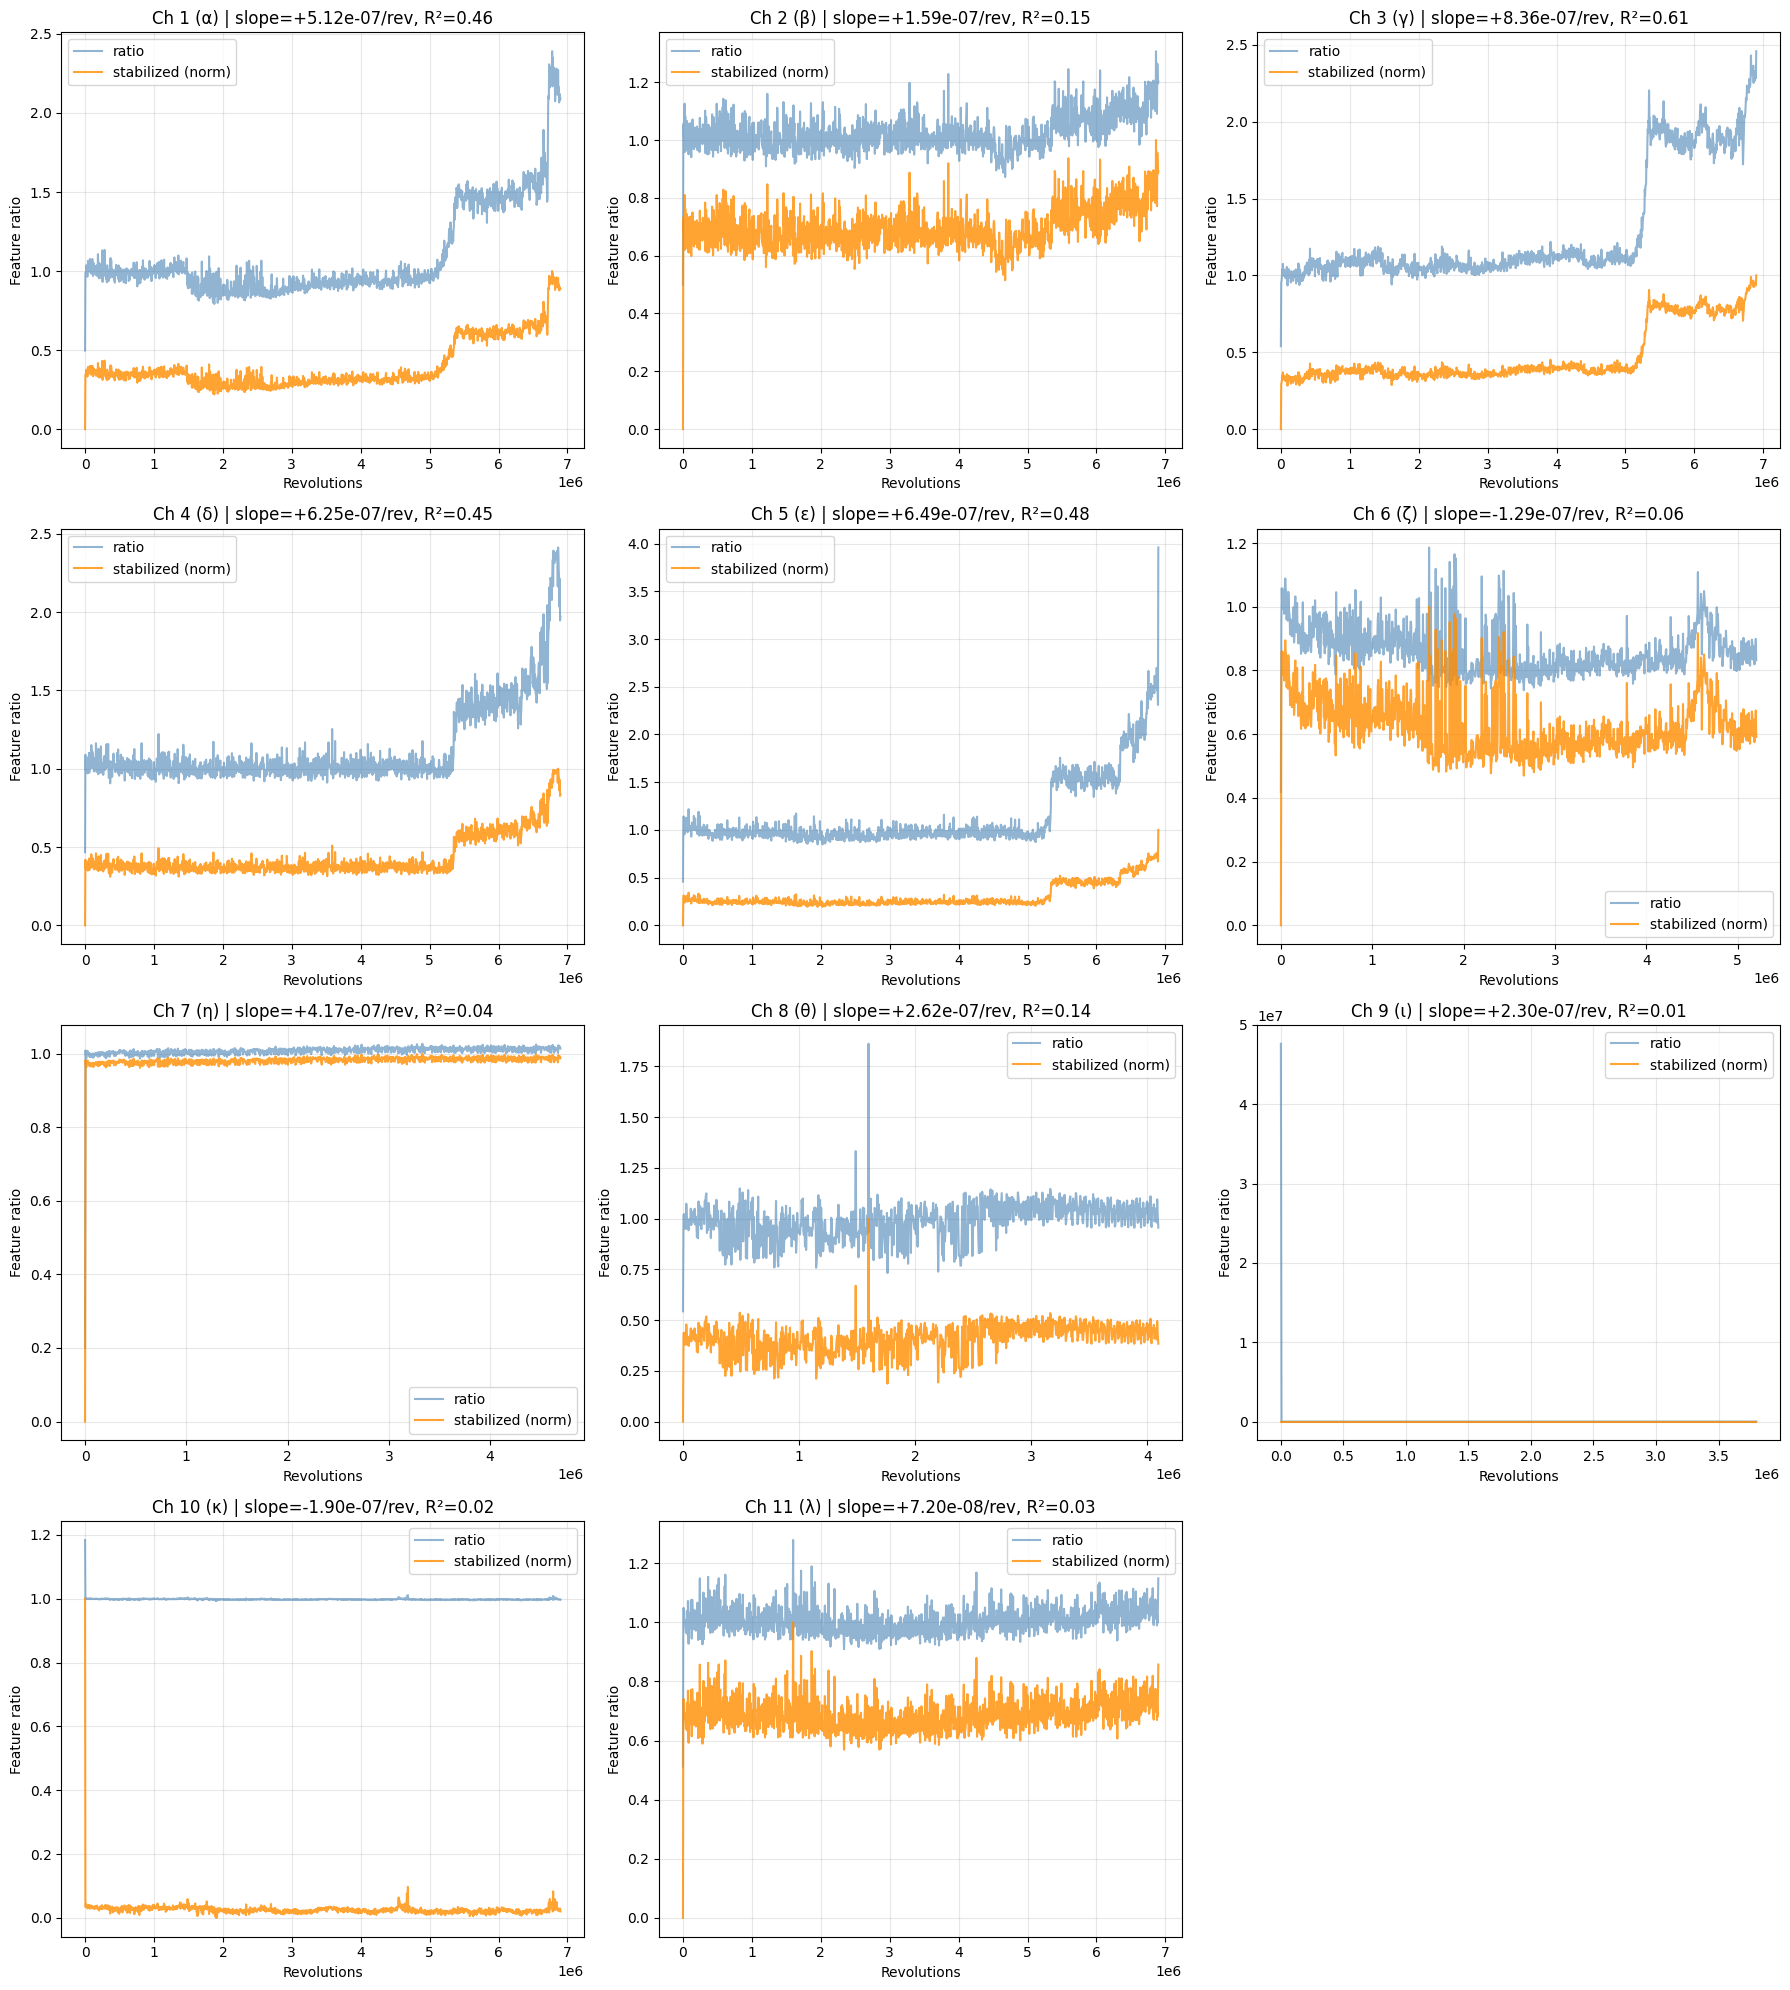

In [ ]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G1'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv', 11: 'channel_11.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G2: Pinion tooth breakage, RPM 2400, Torque 17.9, Lifetime 3102

G2 cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=-1.980070e-07 per rev, R^2=0.229
Channel 2 (β): slope=+1.786235e-07 per rev, R^2=0.269
Channel 3 (γ): slope=+3.674397e-07 per rev, R^2=0.576
Channel 4 (δ): slope=+3.469483e-07 per rev, R^2=0.363
Channel 5 (ε): slope=+3.666210e-07 per rev, R^2=0.347
Channel 6 (ζ): slope=+3.162227e-07 per rev, R^2=0.324
Channel 7 (η): slope=-2.302774e-07 per rev, R^2=0.092
Channel 8 (θ): slope=+6.259584e-08 per rev, R^2=0.033
Channel 9 (ι): slope=+2.807042e-07 per rev, R^2=0.009
Channel 10 (κ): slope=+6.150729e-08 per rev, R^2=0.011


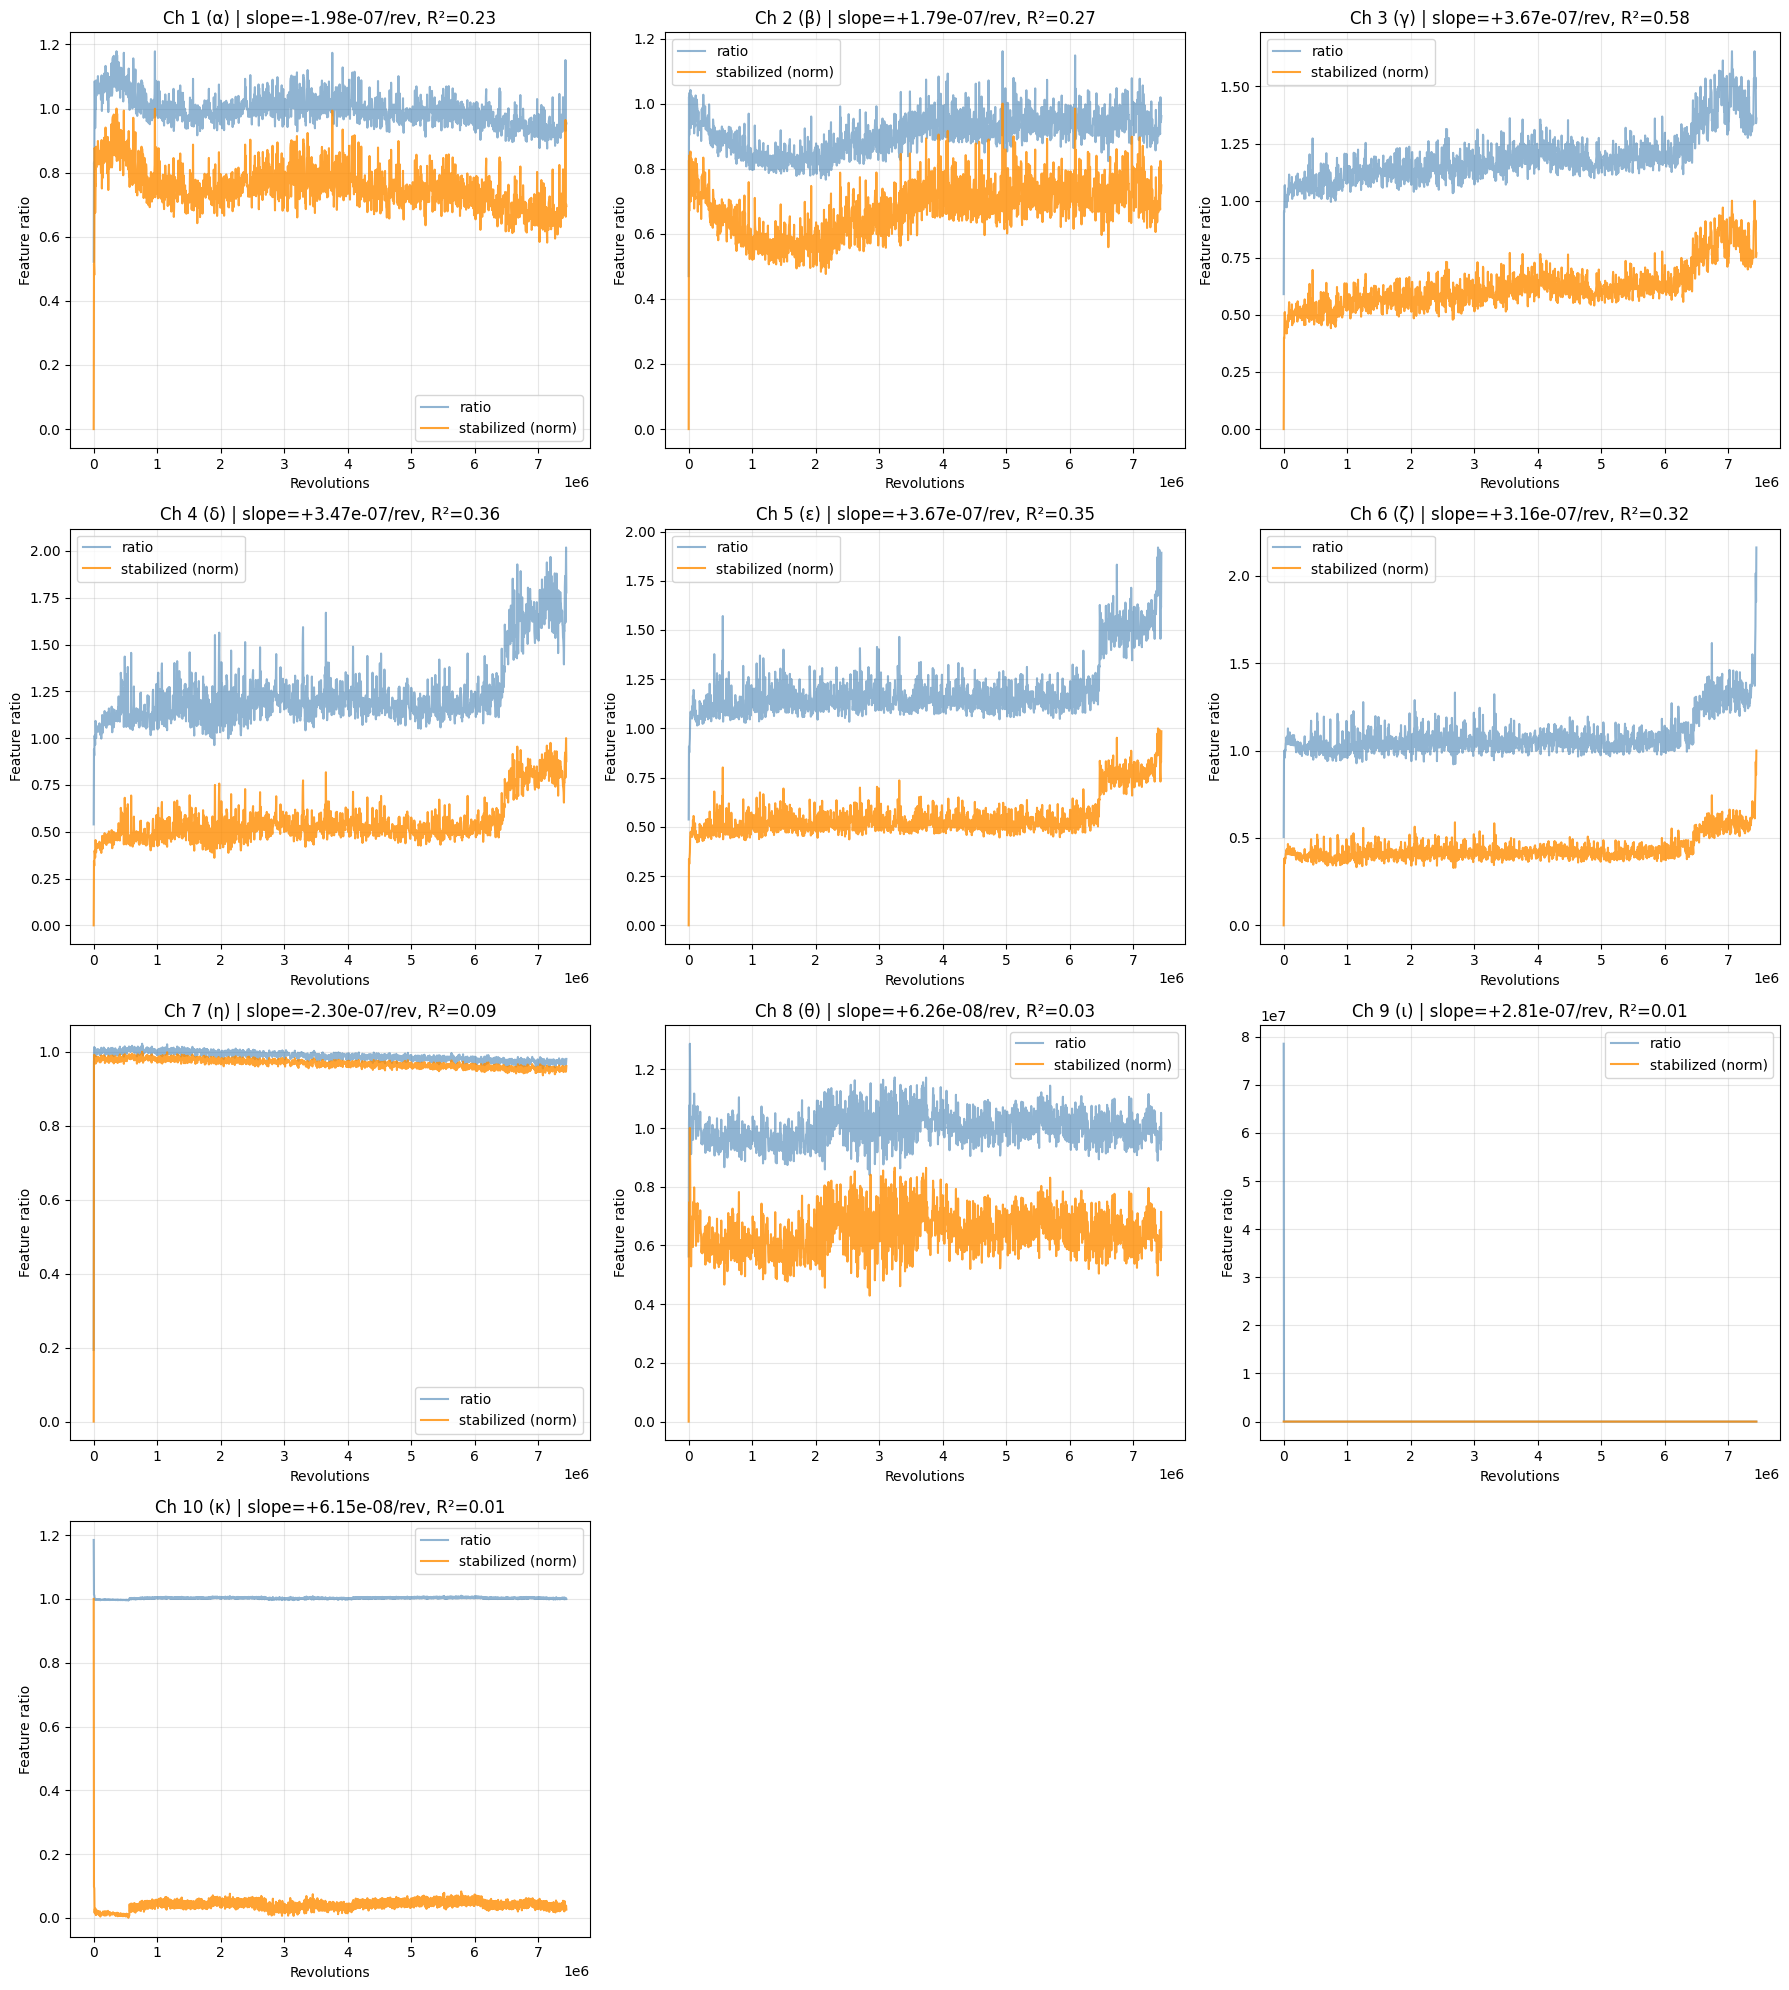

In [12]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G2'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G3: Pinion Spawling and Plastic Deformation; RPM 2400, Torque 17.9, Lifetime 1060

In [ ]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G3'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G4: Pinion pitting and breakage, output gear breakage; RPM 2400, Torque 26.5, lifetime 6504

G5:Pinion breakage, and pitting, and output gear pitting: RPM 2400, Torque 26.5, Lifetime 5862

G6: Test Data set; RPM 2400, Torque 26.5, cause and liftime to be determined.